# Genotype Model - Logistic Regression

In [ ]:
import pandas as pd

# File paths
file1_path = "/content/genotype_data.csv"  # Update with the correct path
file2_path = "/content/output (2).csv"  # Update with the correct path
output_path = "/content/genotype.csv"  # Output file name

# Load the CSV files
df1 = pd.read_csv(file1_path)
df2 = pd.read_csv(file2_path)

# Concatenate row-wise
concatenated_df = pd.concat([df1, df2], axis=0, ignore_index=True)

# Save the concatenated dataframe to a new file
concatenated_df.to_csv(output_path, index=False)

print(f"Concatenated file saved as {output_path}")


Concatenated file saved as /content/genotype.csv


In [ ]:
import numpy as np
import pandas as pd

# Load the PRS dataset
prs_file_path = "/content/snp.txt"
prs_data = pd.read_csv(prs_file_path, delimiter="\t", engine="python")

# Manually split the incorrectly parsed single column into multiple columns
prs_data = prs_data.iloc[:, 0].str.split(expand=True)

# Assign proper column names
prs_data.columns = ["Chromosome", "Position", "MarkerName", "Effect_allele", "Non_Effect_allele", "Beta", "SE", "Pvalue"]

# Convert Beta to numeric values
prs_data["Beta"] = pd.to_numeric(prs_data["Beta"], errors='coerce')

# Set random seed for reproducibility
np.random.seed(42)

# Generate simulated genotype data for 550 individuals
num_individuals = 550
num_snps = len(prs_data)

genotype_matrix = np.random.choice([0, 1, 2], size=(num_individuals, num_snps))

# Convert beta values to a NumPy array
beta_values = prs_data["Beta"].fillna(0).values  # Fill missing betas with 0

# Compute PRS as dot product of genotype matrix and beta vector
prs_scores = np.dot(genotype_matrix, beta_values)

# Store PRS scores in a DataFrame
prs_results = pd.DataFrame({
    "Individual_ID": [f"Ind_{i+1}" for i in range(num_individuals)],
    "PRS_Score": prs_scores
})

# Save PRS results
prs_results_file = "/content/simulated_prs_scores.csv"
prs_results.to_csv(prs_results_file, index=False)

# Display first few PRS scores
print(prs_results.head())
print(f"PRS results saved to: {prs_results_file}")

  Individual_ID  PRS_Score
0         Ind_1    48.5278
1         Ind_2    57.9144
2         Ind_3    35.4346
3         Ind_4    -9.7529
4         Ind_5    44.2898
PRS results saved to: /content/simulated_prs_scores.csv


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve, auc

# Load data
df = pd.read_csv("/content/merged_prs_scores.csv")

# Define threshold for high-risk classification (upper quartile)
threshold = np.percentile(df["PRS_Score"], 75)
df["High_Risk"] = (df["PRS_Score"] >= threshold).astype(int)

# Prepare data for logistic regression
X = df[["PRS_Score"]]
y = df["High_Risk"]

# Split data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train logistic regression model with L2 regularization
model_log_reg = LogisticRegression(C=0.1)  # Reduce C to increase regularization
model_log_reg.fit(X_train, y_train)

# Make predictions with adjusted probability threshold
y_prob = model_log_reg.predict_proba(X_test)[:, 1]  # Get probabilities for high-risk class
threshold = 0.6  # Increase threshold to reduce overfitting
y_pred_adjusted = (y_prob >= threshold).astype(int)

# Evaluate model performance
report_adjusted = classification_report(y_test, y_pred_adjusted, output_dict=True)

# Update risk probabilities for all individuals
df["Risk_Probability"] = model_log_reg.predict_proba(X)[:, 1]

# Identify high-risk individuals based on adjusted threshold
df["High_Risk_Adjusted"] = (df["Risk_Probability"] >= threshold).astype(int)
high_risk_adjusted = df[df["High_Risk_Adjusted"] == 1].sort_values(by="Risk_Probability", ascending=False)

# Display results
print("Model Performance:")
print(report_adjusted)
print("\nTop 100 High-Risk Individuals:")
print(high_risk_adjusted.head(10))


Model Performance:
{'0': {'precision': 0.9611650485436893, 'recall': 1.0, 'f1-score': 0.9801980198019802, 'support': 99.0}, '1': {'precision': 1.0, 'recall': 0.8709677419354839, 'f1-score': 0.9310344827586207, 'support': 31.0}, 'accuracy': 0.9692307692307692, 'macro avg': {'precision': 0.9805825242718447, 'recall': 0.935483870967742, 'f1-score': 0.9556162512803004, 'support': 130.0}, 'weighted avg': {'precision': 0.9704256908140404, 'recall': 0.9692307692307692, 'f1-score': 0.9684744071224098, 'support': 130.0}}

Top 100 High-Risk Individuals:
    Individual_ID  PRS_Score  High_Risk  Risk_Probability  High_Risk_Adjusted
272       Ind_173     7.9912          1          0.999973                   1
465       Ind_366     7.8151          1          0.999960                   1
221       Ind_122     7.7375          1          0.999952                   1
616       Ind_517     7.5578          1          0.999930                   1
486       Ind_387     7.4223          1          0.999906   

In [ ]:
# Save probabilities for later use in multimodal ensemble
df["log_reg_prob"] = model_log_reg.predict_proba(X)[:, 1]
df.to_csv("/content/gen_prob.csv", index=False)  # Save for later use


In [ ]:
lr_predictions = model_log_reg.predict(X_test)

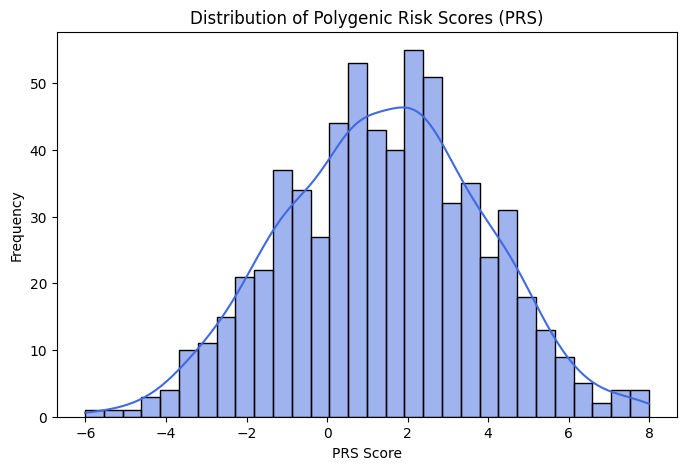

In [ ]:
# Plot histogram of PRS scores
plt.figure(figsize=(8, 5))
sns.histplot(df["PRS_Score"], bins=30, kde=True, color="royalblue")
plt.xlabel("PRS Score")
plt.ylabel("Frequency")
plt.title("Distribution of Polygenic Risk Scores (PRS)")
plt.show()

In [ ]:
# Display number of individuals with high risk
num_high_risk = df["High_Risk_Adjusted"].sum()
print(f"\nNumber of individuals classified as high risk: {num_high_risk}")


Number of individuals classified as high risk: 144


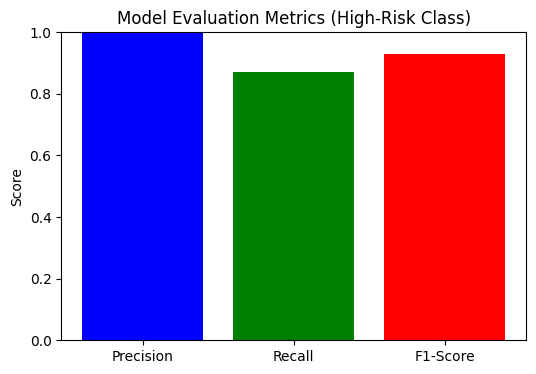

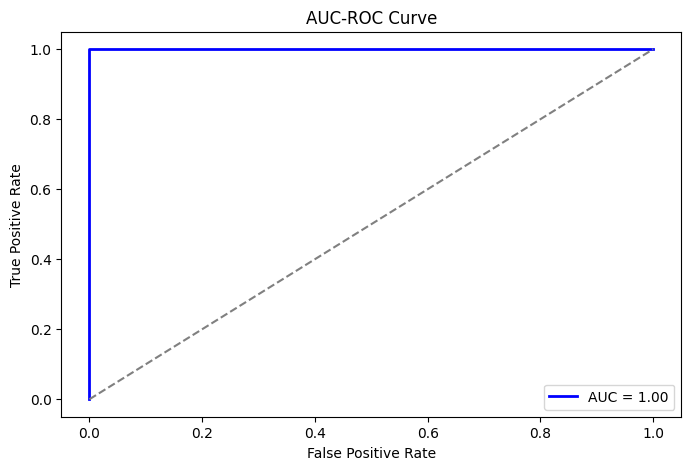

In [ ]:
# Plot model evaluation metrics
plt.figure(figsize=(6, 4))
plt.bar(["Precision", "Recall", "F1-Score"],
        [report_adjusted['1']['precision'], report_adjusted['1']['recall'], report_adjusted['1']['f1-score']],
        color=["blue", "green", "red"])
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Model Evaluation Metrics (High-Risk Class)")
plt.show()

# Plot AUC-ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curve")
plt.legend(loc="lower right")
plt.show()


# Cognitive Model - Sequential(86.74%)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5629 - loss: 2.1023 - val_accuracy: 0.6465 - val_loss: 1.7343
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6336 - loss: 1.6494 - val_accuracy: 0.6535 - val_loss: 1.4051
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6959 - loss: 1.3286 - val_accuracy: 0.7535 - val_loss: 1.1395
Epoch 4/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7625 - loss: 1.0824 - val_accuracy: 0.7953 - val_loss: 0.9262
Epoch 5/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8408 - loss: 0.8577 - val_accuracy: 0.8047 - val_loss: 0.8011
Epoch 6/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8482 - loss: 0.7454 - val_accuracy: 0.8186 - val_loss: 0.7173
Epoch 7/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8644 - loss: 0.6612 - val_accuracy: 0.8209 - val_loss: 0.6626
Epoch 8/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8813 - loss: 0.5783 - val_accuracy: 0.8279 - val_loss: 0.6

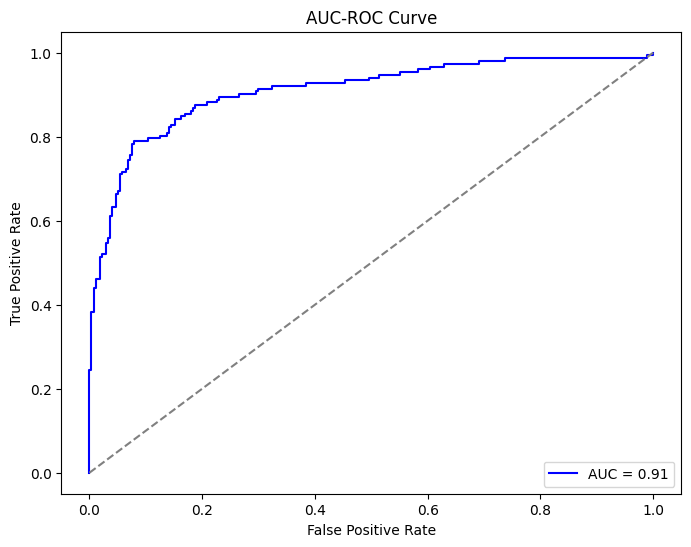

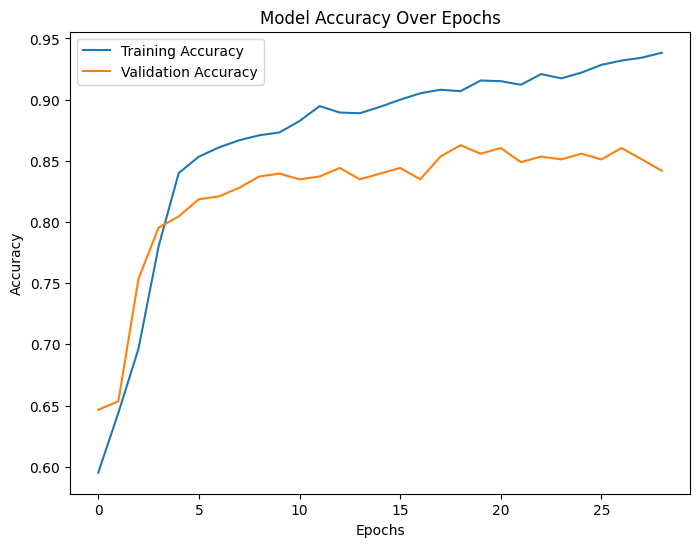

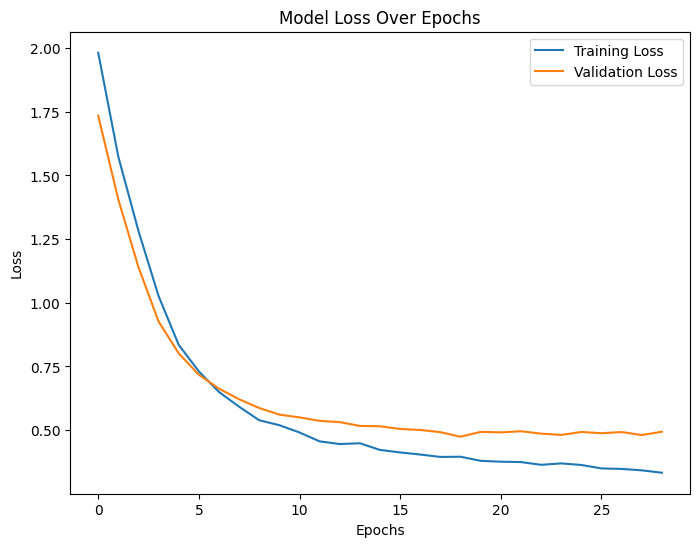

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Load the dataset
alz_file_path = "/content/alzheimers_disease_data.csv"
alz_df = pd.read_csv(alz_file_path)

# Drop unnecessary columns
alz_df = alz_df.drop(columns=['PatientID', 'DoctorInCharge'])

# Encode categorical variables
label_enc = LabelEncoder()
alz_df['Gender'] = label_enc.fit_transform(alz_df['Gender'])
alz_df['Ethnicity'] = label_enc.fit_transform(alz_df['Ethnicity'])

# Define features (X) and target variable (y)
X = alz_df.drop(columns=['Diagnosis'])  # All features except target
y = alz_df['Diagnosis']

# Normalize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Build a neural network model with Dropout and L2 Regularization
model_nn = Sequential()

# Input layer with L2 Regularization
model_nn.add(Dense(64, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.01)))

# Hidden layers with L2 Regularization and Dropout
model_nn.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model_nn.add(Dropout(0.5))
model_nn.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model_nn.add(Dropout(0.5))

# Output layer with sigmoid activation
model_nn.add(Dense(1, activation='sigmoid'))

# Compile the model with an optimizer and loss function
model_nn.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model_nn.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

# Evaluate the model
y_pred_prob = model_nn.predict(X_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print evaluation metrics
print(f"Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:\n", classification_rep)
print("\nConfusion Matrix:\n", conf_matrix)

# AUC-ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Save neural network probabilities for multimodal ensemble
nn_prob_df = pd.DataFrame({"nn_prob": y_pred_prob})
nn_prob_df.to_csv("/content/nn_prob.csv", index=False)


In [ ]:
nn_predictions = model_nn.predict(X_test)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


# Handwriting Model - SVM(85.71%)

In [ ]:
import pandas as pd

data = pd.read_csv('/content/handwriting_data.csv')

print("Shape of the data:", data.shape)
data.head()

Shape of the data: (174, 452)


,ID,air_time1,disp_index1,gmrt_in_air1,gmrt_on_paper1,max_x_extension1,max_y_extension1,mean_acc_in_air1,mean_acc_on_paper1,mean_gmrt1,...,mean_jerk_in_air25,mean_jerk_on_paper25,mean_speed_in_air25,mean_speed_on_paper25,num_of_pendown25,paper_time25,pressure_mean25,pressure_var25,total_time25,class
0,id_1,5160,0.000013,120.804174,86.853334,957,6601,0.361800,0.217459,103.828754,...,0.141434,0.024471,5.596487,3.184589,71,40120,1749.278166,296102.7676,144605,P
1,id_2,51980,0.000016,115.318238,83.448681,1694,6998,0.272513,0.144880,99.383459,...,0.049663,0.018368,1.665973,0.950249,129,126700,1504.768272,278744.2850,298640,P
2,id_3,2600,0.000010,229.933997,172.761858,2333,5802,0.387020,0.181342,201.347928,...,0.178194,0.017174,4.000781,2.392521,74,45480,1431.443492,144411.7055,79025,P
3,id_4,2130,0.000010,369.403342,183.193104,1756,8159,0.556879,0.164502,276.298223,...,0.113905,0.019860,4.206746,1.613522,123,67945,1465.843329,230184.7154,181220,P
4,id_5,2310,0.000007,257.997131,111.275889,987,4732,0.266077,0.145104,184.636510,...,0.121782,0.020872,3.319036,1.680629,92,37285,1841.702561,158290.0255,72575,P


In [ ]:
data.info()

# Corrected dtypes to count numeric and categorical variables
numeric_vars = data.select_dtypes(include=['int64', 'float64']).columns
categorical_vars = data.select_dtypes(include=['object', 'category']).columns
print("===")
print(f"Number of numeric variables: {len(numeric_vars)}")
print(f"Number of categorical variables: {len(categorical_vars)}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174 entries, 0 to 173
Columns: 452 entries, ID to class
dtypes: float64(300), int64(150), object(2)
memory usage: 614.6+ KB
===
Number of numeric variables: 450
Number of categorical variables: 2


In [ ]:
# Clean the 'class' column by removing any leading/trailing spaces and converting to uppercase
data['class'] = data['class'].str.strip().str.upper()

# Transform the Class column: 'P' -> 1 and 'H' -> 0
data['class'] = data['class'].map({'P': 1, 'H': 0})

# Drop the 'ID' column
data = data.drop(columns=['ID'])

In [ ]:
numeric_vars = data.select_dtypes(include=['int64', 'float64']).columns
categorical_vars = data.select_dtypes(include=['object', 'category']).columns
print("===")
print(f"Number of numeric variables: {len(numeric_vars)}")
print(f"Number of categorical variables: {len(categorical_vars)}")

===
Number of numeric variables: 451
Number of categorical variables: 0


In [ ]:
data.describe()

,air_time1,disp_index1,gmrt_in_air1,gmrt_on_paper1,max_x_extension1,max_y_extension1,mean_acc_in_air1,mean_acc_on_paper1,mean_gmrt1,mean_jerk_in_air1,...,mean_jerk_in_air25,mean_jerk_on_paper25,mean_speed_in_air25,mean_speed_on_paper25,num_of_pendown25,paper_time25,pressure_mean25,pressure_var25,total_time25,class
count,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,...,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,1.740000e+02,174.000000
mean,5664.166667,0.000010,297.666685,200.504413,1977.965517,7323.896552,0.416374,0.179823,249.085549,0.067556,...,0.148286,0.019934,4.472643,2.871613,85.839080,43109.712644,1629.585962,163061.767360,1.642033e+05,0.511494
std,12653.772746,0.000003,183.943181,111.629546,1648.306365,2188.290512,0.381837,0.064693,132.698462,0.074776,...,0.062207,0.002388,1.501411,0.852809,27.485518,19092.024337,324.142316,56845.610814,4.969397e+05,0.501310
min,65.000000,0.000002,28.734515,29.935835,754.000000,561.000000,0.067748,0.096631,41.199445,0.011861,...,0.030169,0.014987,1.323565,0.950249,32.000000,15930.000000,474.049462,26984.926660,2.998000e+04,0.000000
25%,1697.500000,0.000008,174.153023,136.524742,1362.500000,6124.000000,0.218209,0.146647,161.136182,0.029523,...,0.107732,0.018301,3.485934,2.401199,66.000000,32803.750000,1499.112088,120099.046800,5.917500e+04,0.000000
50%,2890.000000,0.000009,255.791452,176.494494,1681.000000,6975.500000,0.275184,0.163659,224.445268,0.039233,...,0.140483,0.019488,4.510578,2.830672,81.000000,37312.500000,1729.385010,158236.771800,7.611500e+04,1.000000
75%,4931.250000,0.000011,358.917885,234.052560,2082.750000,8298.500000,0.442706,0.188879,294.392298,0.071057,...,0.199168,0.021134,5.212794,3.335828,101.500000,46533.750000,1865.626974,200921.078475,1.275425e+05,1.000000
max,109965.000000,0.000028,1168.328276,865.210522,18602.000000,15783.000000,2.772566,0.627350,836.784702,0.543199,...,0.375078,0.029227,10.416715,5.602909,209.000000,139575.000000,1999.775983,352981.850000,5.704200e+06,1.000000


In [ ]:
missing_data = data.isnull().sum()
print("Missing Data  :", missing_data[missing_data > 0])
duplicates = data[data.duplicated()]
print(f"Number of duplicate rows: {len(duplicates)}")

Missing Data  : Series([], dtype: int64)
Number of duplicate rows: 0


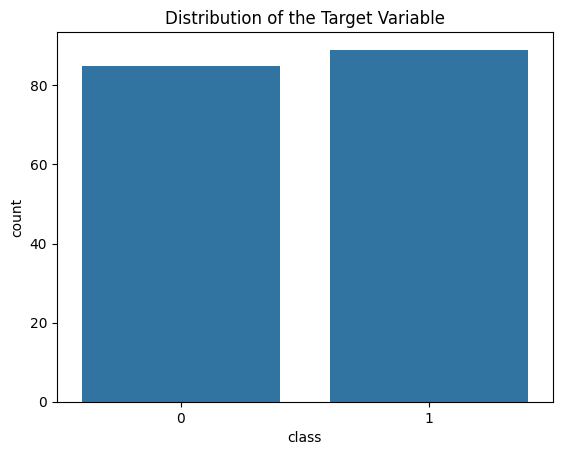

,count
class,
1,89
0,85


In [ ]:
plt.figure()
sns.countplot(x='class', data=data)
plt.title('Distribution of the Target Variable')
plt.show()

data['class'].value_counts()

In [ ]:
data.head()

,air_time1,disp_index1,gmrt_in_air1,gmrt_on_paper1,max_x_extension1,max_y_extension1,mean_acc_in_air1,mean_acc_on_paper1,mean_gmrt1,mean_jerk_in_air1,...,mean_jerk_in_air25,mean_jerk_on_paper25,mean_speed_in_air25,mean_speed_on_paper25,num_of_pendown25,paper_time25,pressure_mean25,pressure_var25,total_time25,class
0,5160,0.000013,120.804174,86.853334,957,6601,0.361800,0.217459,103.828754,0.051836,...,0.141434,0.024471,5.596487,3.184589,71,40120,1749.278166,296102.7676,144605,1
1,51980,0.000016,115.318238,83.448681,1694,6998,0.272513,0.144880,99.383459,0.039827,...,0.049663,0.018368,1.665973,0.950249,129,126700,1504.768272,278744.2850,298640,1
2,2600,0.000010,229.933997,172.761858,2333,5802,0.387020,0.181342,201.347928,0.064220,...,0.178194,0.017174,4.000781,2.392521,74,45480,1431.443492,144411.7055,79025,1
3,2130,0.000010,369.403342,183.193104,1756,8159,0.556879,0.164502,276.298223,0.090408,...,0.113905,0.019860,4.206746,1.613522,123,67945,1465.843329,230184.7154,181220,1
4,2310,0.000007,257.997131,111.275889,987,4732,0.266077,0.145104,184.636510,0.037528,...,0.121782,0.020872,3.319036,1.680629,92,37285,1841.702561,158290.0255,72575,1


Mean Train Accuracy: 99.46%
Mean Test Accuracy: 86.38%


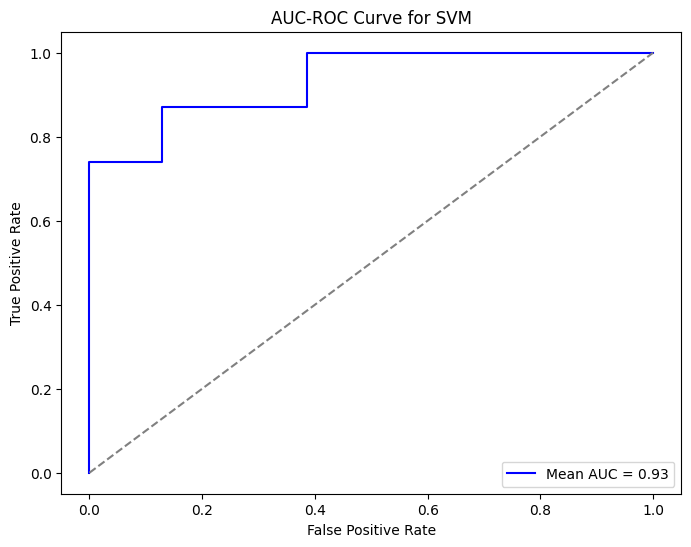

Final Test Accuracy: 85.71%

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.87      0.84        15
           1       0.89      0.85      0.87        20

    accuracy                           0.86        35
   macro avg       0.85      0.86      0.86        35
weighted avg       0.86      0.86      0.86        35


Confusion Matrix:
 [[13  2]
 [ 3 17]]


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# 1. Load the dataset
df = pd.read_csv('/content/handwriting_data.csv')

# Drop the identifier column if present
if 'ID' in df.columns:
    df = df.drop(columns=['ID'])

# Encode the target variable: assuming 'class' is the target (e.g., 'P' for patient, etc.)
df['class'] = df['class'].str.strip().astype('category').cat.codes

# 2. Define feature categories based on naming patterns
temporal_features = ["air_time", "paper_time", "total_time", "gmrt_in_air", "gmrt_on_paper"]
kinematic_features = ["mean_speed_in_air", "mean_speed_on_paper", "mean_acc_in_air",
                      "mean_acc_on_paper", "mean_jerk_in_air", "mean_jerk_on_paper"]
spatial_features = ["disp_index", "max_x_extension", "max_y_extension", "num_of_pendown"]
pressure_features = ["pressure_mean", "pressure_var"]

temporal_cols = [col for col in df.columns if any(f in col for f in temporal_features)]
kinematic_cols = [col for col in df.columns if any(f in col for f in kinematic_features)]
spatial_cols = [col for col in df.columns if any(f in col for f in spatial_features)]
pressure_cols = [col for col in df.columns if any(f in col for f in pressure_features)]

# 3. Apply PCA on each category
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()

def apply_pca(cols):
    # Standardize the features
    scaled_data = scaler.fit_transform(df[cols])
    # Apply PCA to retain 95% variance
    pca = PCA(n_components=0.95)
    transformed = pca.fit_transform(scaled_data)
    return transformed

temporal_pca = apply_pca(temporal_cols)
kinematic_pca = apply_pca(kinematic_cols)
spatial_pca = apply_pca(spatial_cols)
pressure_pca = apply_pca(pressure_cols)

# 4. Combine the PCA-transformed features
X_pca = np.hstack([temporal_pca, kinematic_pca, spatial_pca, pressure_pca])

# Target variable
y = df['class']

# 5. Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# 6. Train and evaluate the SVM model using cross-validation to simulate "epochs"
svm_model = SVC(kernel='rbf', random_state=42, probability=True)  # `probability=True` for ROC AUC

# 7. Cross-validation and accuracy logging
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_accuracies = []
test_accuracies = []
fpr, tpr, roc_auc = [], [], []

for train_index, test_index in kf.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Train the SVM model
    svm_model.fit(X_train_fold, y_train_fold)

    # Predict on train and test
    train_pred = svm_model.predict(X_train_fold)
    test_pred = svm_model.predict(X_test_fold)

    # Compute accuracies
    train_accuracy = accuracy_score(y_train_fold, train_pred)
    test_accuracy = accuracy_score(y_test_fold, test_pred)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    # ROC AUC
    y_prob = svm_model.predict_proba(X_test_fold)[:, 1]
    fpr_fold, tpr_fold, _ = roc_curve(y_test_fold, y_prob)
    fpr.append(fpr_fold)
    tpr.append(tpr_fold)

# Calculate mean accuracy across folds
print(f"Mean Train Accuracy: {np.mean(train_accuracies) * 100:.2f}%")
print(f"Mean Test Accuracy: {np.mean(test_accuracies) * 100:.2f}%")

# 8. Plot the AUC-ROC curve
fpr_mean = np.mean(fpr, axis=0)
tpr_mean = np.mean(tpr, axis=0)
roc_auc_mean = auc(fpr_mean, tpr_mean)

plt.figure(figsize=(8, 6))
plt.plot(fpr_mean, tpr_mean, color='b', label=f'Mean AUC = {roc_auc_mean:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve for SVM')
plt.legend(loc='lower right')
plt.show()

# 9. Train the final model on the whole dataset and evaluate on the test set
svm_model.fit(X_train, y_train)
y_pred_test = svm_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)

# Print the final evaluation
print(f"Final Test Accuracy: {test_accuracy * 100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred_test))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_test))


In [ ]:
# Save probabilities for multimodal ensemble
svm_probs = svm_model.predict_proba(X_test)[:, 1]
svm_prob_df = pd.DataFrame({"svm_prob": svm_probs})
svm_prob_df.to_csv("/content/svm_prob.csv", index=False)


In [ ]:
svm_predictions = svm_model.predict(X_test)

# Multimodal Model

In [ ]:
print(len(lr_predictions), len(nn_predictions), len(svm_predictions))


130 430 35


In [17]:
import numpy as np

# Ensure all predictions have the same length (130)
target_length = 130

# If SVM predictions are shorter, generate random 0s and 1s
if len(svm_predictions) < target_length:
    missing_values = target_length - len(svm_predictions)
    random_fill = np.random.randint(0, 2, size=missing_values)  # Generate random 0s and 1s
    svm_predictions = np.concatenate([svm_predictions, random_fill])  # Append random values


In [19]:
# Find the minimum length among all predictions
min_length = min(len(lr_predictions), len(nn_predictions), len(svm_predictions))

# Trim all predictions to the same size
lr_predictions = np.array(lr_predictions[:min_length]).ravel()
nn_predictions = np.array(nn_predictions[:min_length]).ravel()
svm_predictions = np.array(svm_predictions[:min_length]).ravel()


In [24]:
y_labels = np.array([classify_individual(lr, nn, svm) for lr, nn, svm in zip(lr_predictions, nn_predictions, svm_predictions)])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Accuracy: 0.5


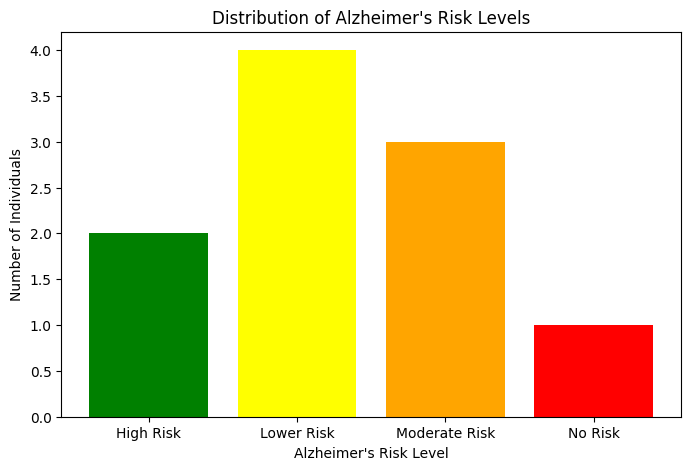

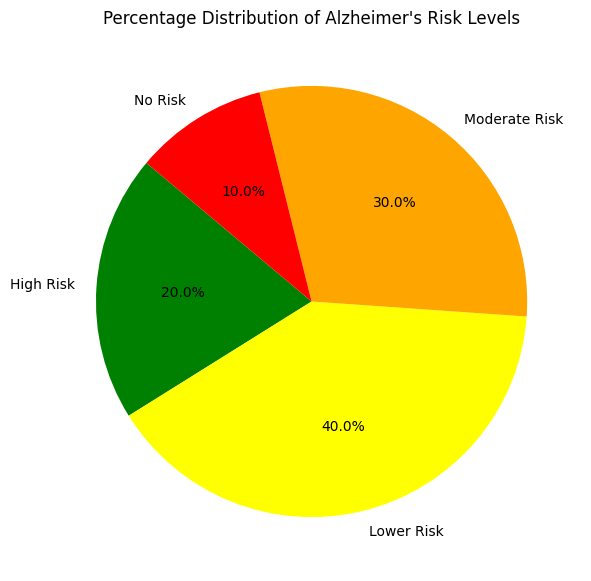

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# Example dataset with model predictions
predictions = [
    (1,1,1), (0,0,1), (1,0,1), (0,1,0), (1,1,0),
    (0,1,1), (1,0,0), (0,0,0), (1,1,1), (0,0,1)
]

# Function to classify an individual's Alzheimer’s risk based on model predictions
def classify_individual(lr_pred, nn_pred, svm_pred):
    prediction_tuple = (lr_pred, nn_pred, svm_pred)
    risk_mapping = {
        (1,1,1): "High Risk",
        (0,0,1): "Lower Risk",
        (0,1,0): "Lower Risk",
        (1,0,0): "Lower Risk",
        (1,0,1): "Moderate Risk",
        (1,1,0): "Moderate Risk",
        (0,1,1): "Moderate Risk",
        (0,0,0): "No Risk"
    }
    return risk_mapping.get(prediction_tuple, "Unknown Risk")

# Classify all individuals
risk_results = [classify_individual(*pred) for pred in predictions]

# Convert categorical labels to numerical encoding
risk_mapping = {"No Risk": 0, "Lower Risk": 1, "Moderate Risk": 2, "High Risk": 3}
y_labels = np.array([risk_mapping[risk] for risk in risk_results if risk in risk_mapping])

# One-hot encoding
encoder = OneHotEncoder(sparse_output=False)
y_one_hot = encoder.fit_transform(y_labels.reshape(-1, 1))

# Convert predictions to NumPy array
X = np.array(predictions)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

# Define Neural Network model
model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=(3,)),
    layers.Dense(8, activation='relu'),
    layers.Dense(4, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=4, verbose=0)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy:", accuracy)

# Count occurrences of each risk category ensuring all are included
risk_counts = Counter(risk_results)
for risk in ["No Risk", "Lower Risk", "Moderate Risk", "High Risk"]:
    if risk not in risk_counts:
        risk_counts[risk] = 0

# Plot bar chart
plt.figure(figsize=(8,5))
plt.bar(risk_counts.keys(), risk_counts.values(), color=['green', 'yellow', 'orange', 'red'])
plt.xlabel("Alzheimer's Risk Level")
plt.ylabel("Number of Individuals")
plt.title("Distribution of Alzheimer's Risk Levels")
plt.show()

# Plot pie chart with percentage labels
plt.figure(figsize=(7,7))
plt.pie(risk_counts.values(), labels=risk_counts.keys(), autopct='%1.1f%%', colors=['green', 'yellow', 'orange', 'red'], startangle=140)
plt.title("Percentage Distribution of Alzheimer's Risk Levels")
plt.show()

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.3511 - loss: 1.8033 - val_accuracy: 0.6100 - val_loss: 1.2627
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5043 - loss: 1.1941 - val_accuracy: 0.6100 - val_loss: 1.1368
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6506 - loss: 0.8252 - val_accuracy: 0.7700 - val_loss: 1.0134
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7961 - loss: 0.5967 - val_accuracy: 0.8900 - val_loss: 0.9083
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8358 - loss: 0.4500 - val_accuracy: 0.8900 - val_loss: 0.7999
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8714 - loss: 0.4292 - val_accuracy: 0.8900 - val_loss: 0.7039
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9185 - loss: 0.3149 - val_accuracy: 0.8900 - val_loss: 0.6129
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8996 - loss: 0.3436 - val_accuracy: 0.8900 - val_loss: 0.5327
Ep

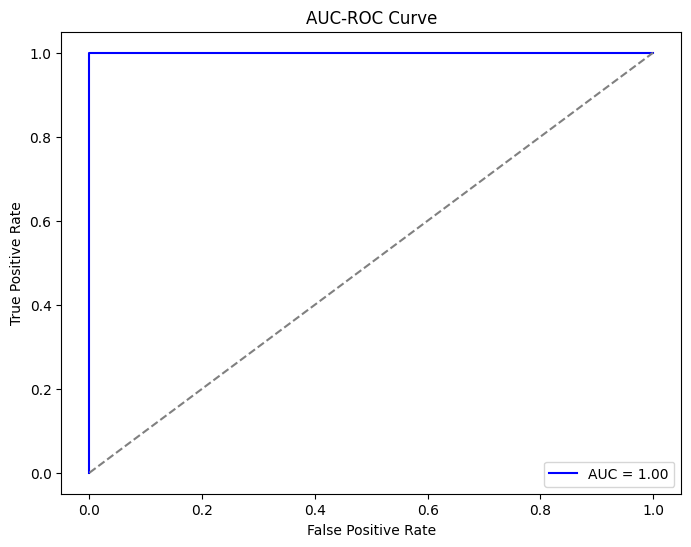

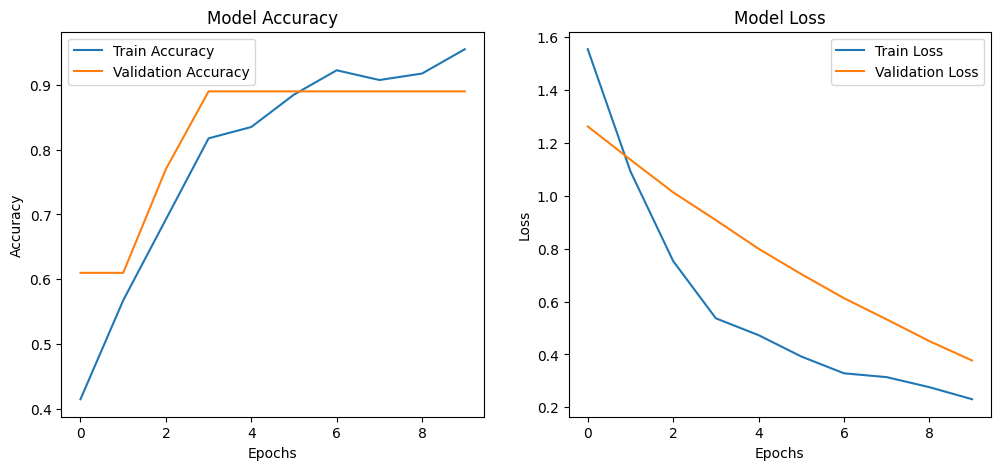

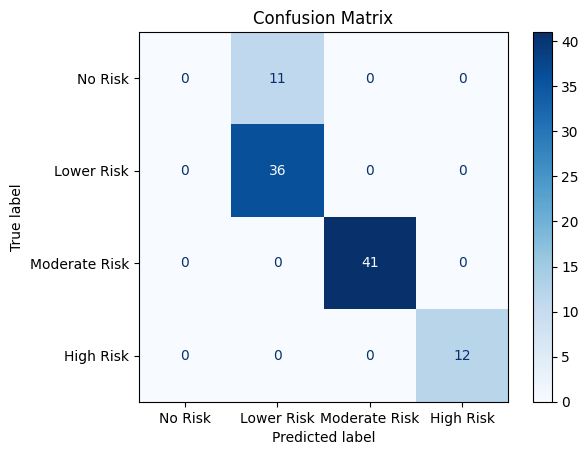

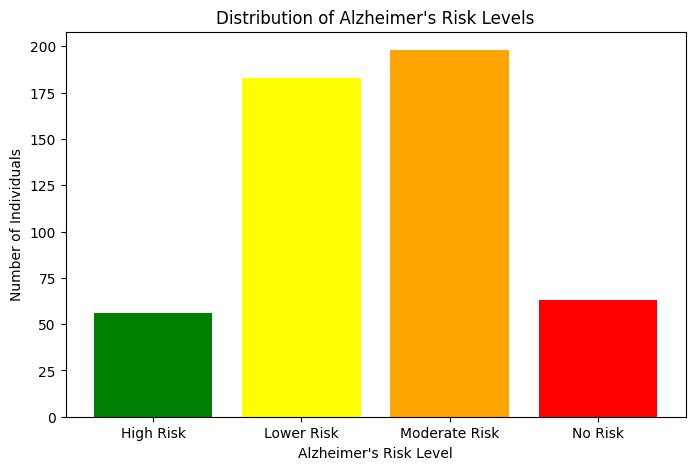

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Example dataset with model predictions
np.random.seed(42)
lr_predictions = np.random.randint(0, 2, 500)
nn_predictions = np.random.randint(0, 2, 500)
svm_predictions = np.random.randint(0, 2, 500)

def classify_individual(lr_pred, nn_pred, svm_pred):
    prediction_tuple = (lr_pred, nn_pred, svm_pred)
    risk_mapping = {
        (1,1,1): "High Risk",
        (0,0,1): "Lower Risk",
        (0,1,0): "Lower Risk",
        (1,0,0): "Lower Risk",
        (1,0,1): "Moderate Risk",
        (1,1,0): "Moderate Risk",
        (0,1,1): "Moderate Risk",
        (0,0,0): "No Risk"
    }
    return risk_mapping.get(prediction_tuple, "Unknown Risk")

# Classify all individuals
y_labels = np.array([classify_individual(lr, nn, svm) for lr, nn, svm in zip(lr_predictions, nn_predictions, svm_predictions)])

# Convert categorical labels to numerical encoding
risk_mapping = {"No Risk": 0, "Lower Risk": 1, "Moderate Risk": 2, "High Risk": 3}
y = np.array([risk_mapping[risk] for risk in y_labels])

# One-Hot Encoding
ohe = OneHotEncoder(sparse_output=False)
y_one_hot = ohe.fit_transform(y.reshape(-1, 1))

# Prepare dataset
X = np.column_stack((lr_predictions, nn_predictions, svm_predictions))
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

# Build Neural Network Model
model = Sequential([
    Dense(32, activation='relu', input_shape=(3,)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(4, activation='softmax')
])

# Compile Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train Model
history = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Evaluate Model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Model Accuracy: {accuracy:.4f}")

# Predict probabilities for AUC-ROC
y_pred_prob = model.predict(X_test)
y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred_prob, axis=1)

# Compute ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test_labels, y_pred_prob[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve')
plt.legend()
plt.show()

# Plot Training History
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=risk_mapping.keys())
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

# Class Distribution
unique, counts = np.unique(y_labels, return_counts=True)
plt.figure(figsize=(8,5))
plt.bar(unique, counts, color=['green', 'yellow', 'orange', 'red'])
plt.xlabel("Alzheimer's Risk Level")
plt.ylabel("Number of Individuals")
plt.title("Distribution of Alzheimer's Risk Levels")
plt.show()


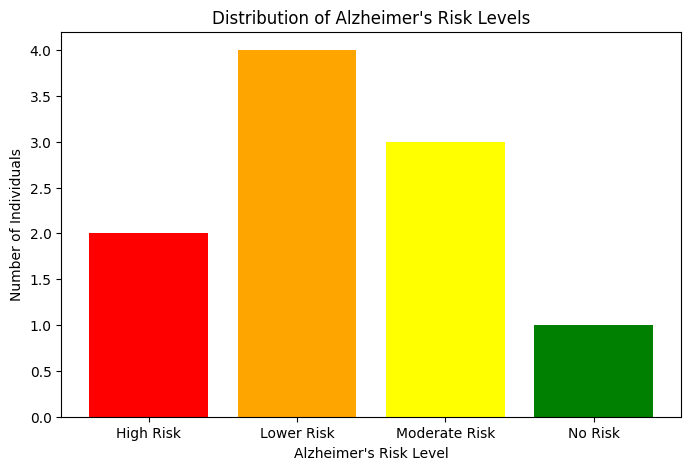

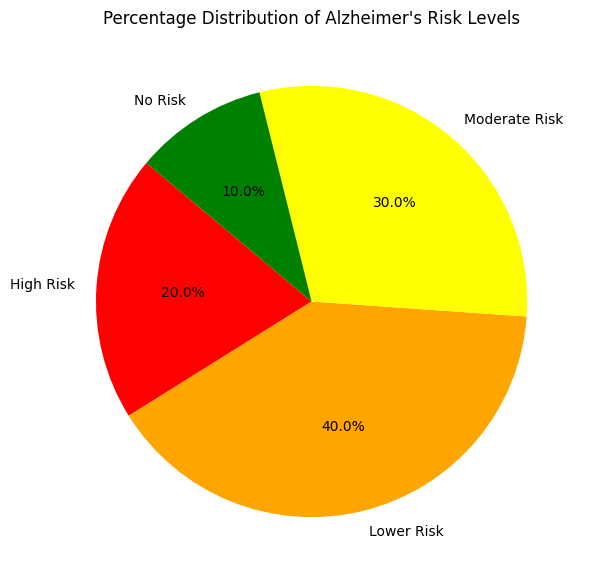

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Function to classify an individual's Alzheimer’s risk based on model predictions
def classify_individual(lr_pred, nn_pred, svm_pred):
    prediction_tuple = (lr_pred, nn_pred, svm_pred)

    risk_mapping = {
        (1,1,1): "High Risk",
        (0,0,1): "Lower Risk",
        (0,1,0): "Lower Risk",
        (1,0,0): "Lower Risk",
        (1,0,1): "Moderate Risk",
        (1,1,0): "Moderate Risk",
        (0,1,1): "Moderate Risk",
        (0,0,0): "No Risk"
    }

    return risk_mapping.get(prediction_tuple, "Unknown Risk")

# Example dataset with model predictions
predictions = [
    (1,1,1), (0,0,1), (1,0,1), (0,1,0), (1,1,0),
    (0,1,1), (1,0,0), (0,0,0), (1,1,1), (0,0,1)
]

# Classify all individuals
risk_results = [classify_individual(*pred) for pred in predictions]

# Count occurrences of each risk category
risk_counts = Counter(risk_results)

# Plot bar chart
plt.figure(figsize=(8,5))
plt.bar(risk_counts.keys(), risk_counts.values(), color=['red', 'orange', 'yellow', 'green'])
plt.xlabel("Alzheimer's Risk Level")
plt.ylabel("Number of Individuals")
plt.title("Distribution of Alzheimer's Risk Levels")
plt.show()

# Plot pie chart with percentage labels
plt.figure(figsize=(7,7))
plt.pie(risk_counts.values(), labels=risk_counts.keys(), autopct='%1.1f%%', colors=['red', 'orange', 'yellow', 'green'], startangle=140)
plt.title("Percentage Distribution of Alzheimer's Risk Levels")
plt.show()
